# LF Band Optimizations
2/4/2023
The current definitions of the LF band edges are not compatible with the fractional bandwidth restriction given our feedhorn/OMT architecture.  We need to reduce the fractional bandwidth by a small amount.  This notebook explores such changes through their impact on NET.

2/27/2023
In discussion with Besuner, Kovac and Simons, it looks like fitting the SAT LF pixels (driven by the OMT) on a 19-pixel wafer requires the lower edge of the LF_1 band be at least 23.1 GHz.  Given this, the question is how that
affects NET, how it affects some metric of synchrotron sensitivity, and whether we can win back losses in those
by moving the crossover split frequency (between the two bands), and/or the upper edge of the LF_2 band.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import yaml
import sys
#sys.path.insert(0,'/Users/ruhl/code/jbolo/python/')
from  jbolo_funcs import *

%matplotlib inline
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [8, 10]

First, let's do this using flat bands, for all three telescopes.

In [2]:
!ls yamls

CHLAT_20230122.yaml SAT_20230122.yaml   SPLAT_20230122.yaml


In [3]:
sim = {}
chlist = ['LF_1','LF_2'] 

tels = ['CHLAT','SPLAT','SAT']
yamls = {'CHLAT':'CHLAT_20230122.yaml','SPLAT':'SPLAT_20230122.yaml','SAT':'SAT_20230122.yaml'}
out = {}  # outputs we're saving for later plotting
         
for tel in tels:
    print(tel)
    yamlfile = yamls[tel]
    print(yamlfile)
    sim.clear()
    sim = yaml.safe_load(open('yamls/'+yamlfile))
    
    # Kill all the extra channels so we don't waste time computing them.
    fullchlist = list(sim['channels'].keys())
    for ch in fullchlist:
        if ch not in chlist:
            del sim['channels'][ch]
    
    # We're only doing the LF's
    #chlist = list(sim['channels'].keys())

    # The bands in the yaml file are flat bands;  let's use the edges to determine
    # the default band center and width, and then vary those by +- 5% in band center and width.
    # This will create a 2D array of input (center,width) parameters, and we'll calculate
    # P_optical and NET for each point in the 2D space.
    #
    nbins = 40
    center_scalefactor = np.linspace(0.9,1.1,nbins)
    width_scalefactor = np.linspace(0.7,1.1,nbins)
 
    plottitle= sim['sources']['atmosphere']['site']+', pvw='+str(sim['sources']['atmosphere']['pwv'])
    print(plottitle)

    out[tel]= {'NET':{}, 'NETrj':{}, 'Popt':{}, 'center':{}, 'width':{}}
    for keyn in out[tel].keys():
        for ch in chlist:
            out[tel][keyn][ch] = np.empty((nbins,nbins))

    for ch in chlist:
        # Save the low and high edges, for use later in scaling
        sim['channels'][ch]['nu_low_0']  = sim['channels'][ch]['nu_low']
        sim['channels'][ch]['nu_high_0'] = sim['channels'][ch]['nu_high']
        sim['channels'][ch]['nu_center0'] = (sim['channels'][ch]['nu_high_0'] + sim['channels'][ch]['nu_low_0'])/2.0
        sim['channels'][ch]['nu_width0']  = sim['channels'][ch]['nu_high_0'] - sim['channels'][ch]['nu_low_0']
    
    cc = 0  # this serves as an array index for the "center factor"
    for cf in center_scalefactor:
        ww = 0  # this serves as an array index for the "width factor"
        for wf in width_scalefactor:
            if 'outputs' in sim.keys():  
                sim['outputs'].clear()  # Clear previous iteration results so things don't multiply.
            for ch in chlist:
                _outwidth  = wf*sim['channels'][ch]['nu_width0']
                _outcenter = cf*sim['channels'][ch]['nu_center0']
                sim['channels'][ch]['nu_low']  = _outcenter - (_outwidth/2.0)
                sim['channels'][ch]['nu_high'] = _outcenter + (_outwidth/2.0)
                out[tel]['center'][ch][ww][cc] = _outcenter
                out[tel]['width'][ch][ww][cc]  = _outwidth
                
            # run jbolo
            run_optics(sim)
            run_bolos(sim)
            
            for ch in chlist:
                out[tel]['NET'][ch][ww][cc] = sim['outputs'][ch]['NET_NC_total']
                out[tel]['NETrj'][ch][ww][cc] = sim['outputs'][ch]['NETrj_NC_total']
                out[tel]['Popt'][ch][ww][cc]= sim['outputs'][ch]['P_opt']
    
            ww += 1
        cc += 1



CHLAT
CHLAT_20230122.yaml
Atacama, pvw=993
SPLAT
SPLAT_20230122.yaml
Pole, pvw=321
SAT
SAT_20230122.yaml
Pole, pvw=321


In [4]:
out['CHLAT']['width']['LF_1'][:,0]

array([5.95      , 6.03717949, 6.12435897, 6.21153846, 6.29871795,
       6.38589744, 6.47307692, 6.56025641, 6.6474359 , 6.73461538,
       6.82179487, 6.90897436, 6.99615385, 7.08333333, 7.17051282,
       7.25769231, 7.34487179, 7.43205128, 7.51923077, 7.60641026,
       7.69358974, 7.78076923, 7.86794872, 7.95512821, 8.04230769,
       8.12948718, 8.21666667, 8.30384615, 8.39102564, 8.47820513,
       8.56538462, 8.6525641 , 8.73974359, 8.82692308, 8.91410256,
       9.00128205, 9.08846154, 9.17564103, 9.26282051, 9.35      ])

# Plot NETs

Text(0.5, 0.98, 'NET_RJ (uKrtsec) vs LF band centers and widths')

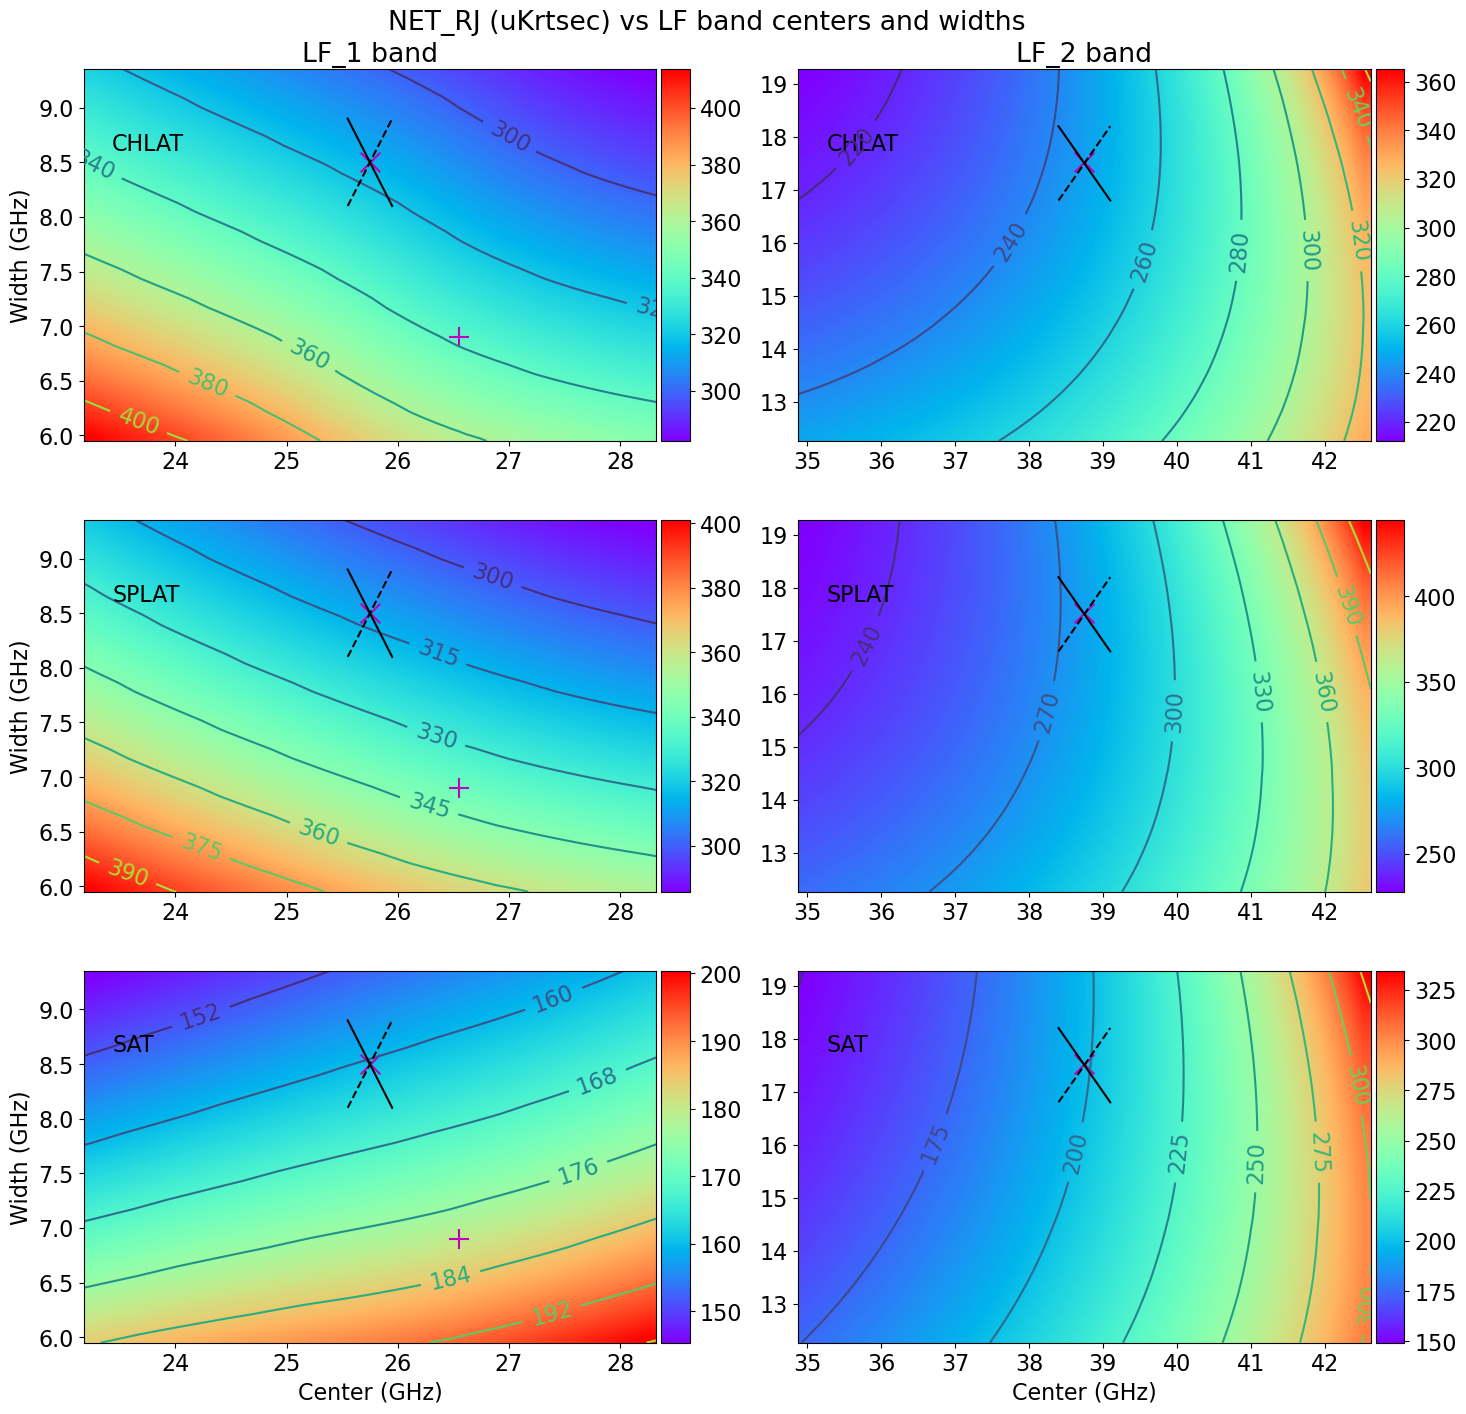

In [5]:
plt.rcParams['figure.figsize'] = [14, 14]
plt.rcParams.update({'font.size': 16})

# Proposaed new LF_1 band, which has same upper edge, and lower edge at 21.7GHz
#
LF_1_newcenter = (30.0+23.1)/2.
LF_1_newwidth = 30.0 - 23.1

# make a line that goes through the old center for the LF_1 band
x0_1 = (30+21.5)/2
y0_1 = (30-21.5)
dnu_1 = np.linspace(-0.4,.4,100)  # amount low edge of band moves up, 0 to 2 GHz
x_1_movelow = x0_1 + dnu_1/2  # center of band moves up by dnu/2
y_1_movelow = y0_1 - dnu_1    # bandwidth gets smaller by dnu
x_1_movehigh = x0_1 + dnu_1/2  # center of band moves up by dnu/2
y_1_movehigh = y0_1 + dnu_1    # bandwidth gets smaller by dnu

#
# make a line that goes through the old center for the LF_2 band
x0_2 = (47.5 + 30.0)/2
y0_2 = (47.5-30.0)
dnu_2 = np.linspace(-0.7,0.7,100)  # amount low edge of band moves up, 0 to 2 GHz
x_2_movelow = x0_2 + dnu_2/2  # center of band moves up by dnu/2
y_2_movelow = y0_2 - dnu_2    # bandwidth gets smaller by dnu
x_2_movehigh = x0_2 + dnu_2/2  # center of band moves up by dnu/2
y_2_movehigh = y0_2 + dnu_2    # bandwidth gets smaller by dnu

npl_x = 2
npl_y = 3

fig, axs = plt.subplots(nrows=npl_y,ncols=npl_x,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.1,
                                wspace=0.1)

# CHLAT, LF_1
rownum = 0
for tel in ['CHLAT','SPLAT','SAT']:
    colnum = 0
    for ch in ['LF_1','LF_2']:
        netarr = 1e6*out[tel]['NETrj'][ch]
        abc= axs[rownum,colnum].imshow(netarr,interpolation='bilinear',cmap='rainbow',origin='lower',aspect='auto',extent=(np.min(out[tel]['center'][ch]),np.max(out[tel]['center'][ch]),np.min(out[tel]['width'][ch]),np.max(out[tel]['width'][ch])))
        
        cvec = out[tel]['center'][ch][0,:]
        wvec = out[tel]['width'][ch][:,0]
        cset = axs[rownum,colnum].contour(cvec,wvec,netarr) #,levels,colors='w')
        axs[rownum,colnum].clabel(cset)#, levels,fmt='%i mK',fontsize=8)
        axs[rownum,colnum].text(0.05, 0.8, tel, horizontalalignment='left',verticalalignment='center', transform=axs[rownum,colnum].transAxes)
        divider = make_axes_locatable(axs[rownum,colnum])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        axs[rownum,colnum].scatter(sim['channels'][ch]['nu_center0'],sim['channels'][ch]['nu_width0'],s=200,marker='x',c='m')
        fig.colorbar(abc, cax=cax, orientation='vertical')
        colnum = colnum + 1
    rownum = rownum + 1
    
for row in [0,1,2]:
    axs[row,0].scatter(LF_1_newcenter,LF_1_newwidth,s=200,marker='+',c='m')
    axs[row,0].plot(x_1_movelow,y_1_movelow,'-k')
    axs[row,1].plot(x_2_movelow,y_2_movelow,'-k')
    axs[row,0].plot(x_1_movehigh,y_1_movehigh,'--k')
    axs[row,1].plot(x_2_movehigh,y_2_movehigh,'--k')
    axs[row,0].set_ylabel('Width (GHz)')

                                                                          
axs[0,0].set_title('LF_1 band')
axs[0,1].set_title('LF_2 band')
#for jj in range(len(chlist)):
#    axs[jj,0].set_ylabel('width (GHz)')
#axs[0,3].legend(loc='upper right')
axs[npl_y-1,0].set_xlabel('Center (GHz)')
axs[npl_y-1,1].set_xlabel('Center (GHz)')

fig.suptitle('NET_RJ (uKrtsec) vs LF band centers and widths')
        

# Interpretation of the above plots

The CMB-S4 "current baseline" band centers and widths are marked with an "x".  The "+" marks what we'd get for an LF_1 band if we simply raise the lower edge of that band to the new value, without changing the crossover split frequency.  

From the "x", if you move the lower edge up or down in frequency but leave the upper edge fixed, you move along the solid black line.  If you do a similar thing but with the upper band edge you move along the dashed black line.

If you leave the band center fixed and change the bandwidth, you of course move horizontally.

The CHLAT and SPLAT color contours look similar, as expected.  

The SAT LF_1 contour looks significantly different than the LAT ones;  I think this is because the horn size is fixed in these calculations, and the LATs LF_1's get much more optically efficient at the Lyot stop as you move to high frequency, which is improving the NET in a way the SAT version does not.  

The LF_2 bands in all cases are fairly independent of bandwidth, at least over the range plotted.  This may be because we're dominated by Bose photon noise, but that's checkable.

I think these plots indicate that if you're trying to reduce the fractional bandwidth of the LF bands, you're probably better off moving the LF_2 band edges rather than LF_1.  I'll make plots of various options below.  I'm just going to interpolate over the arrays shown above, rather than rerun jbolo along the new lines.  (The interpolation is not great, so the lines will be squiggly.)

# Plot Noise Equivalent Synchrotron (NES)
Use same code as above, but plot NETrj*nu^2.7  (gets worse going to high frequency)

Text(0.5, 0.98, 'NESynchrotron (arb units) vs LF band centers and widths')

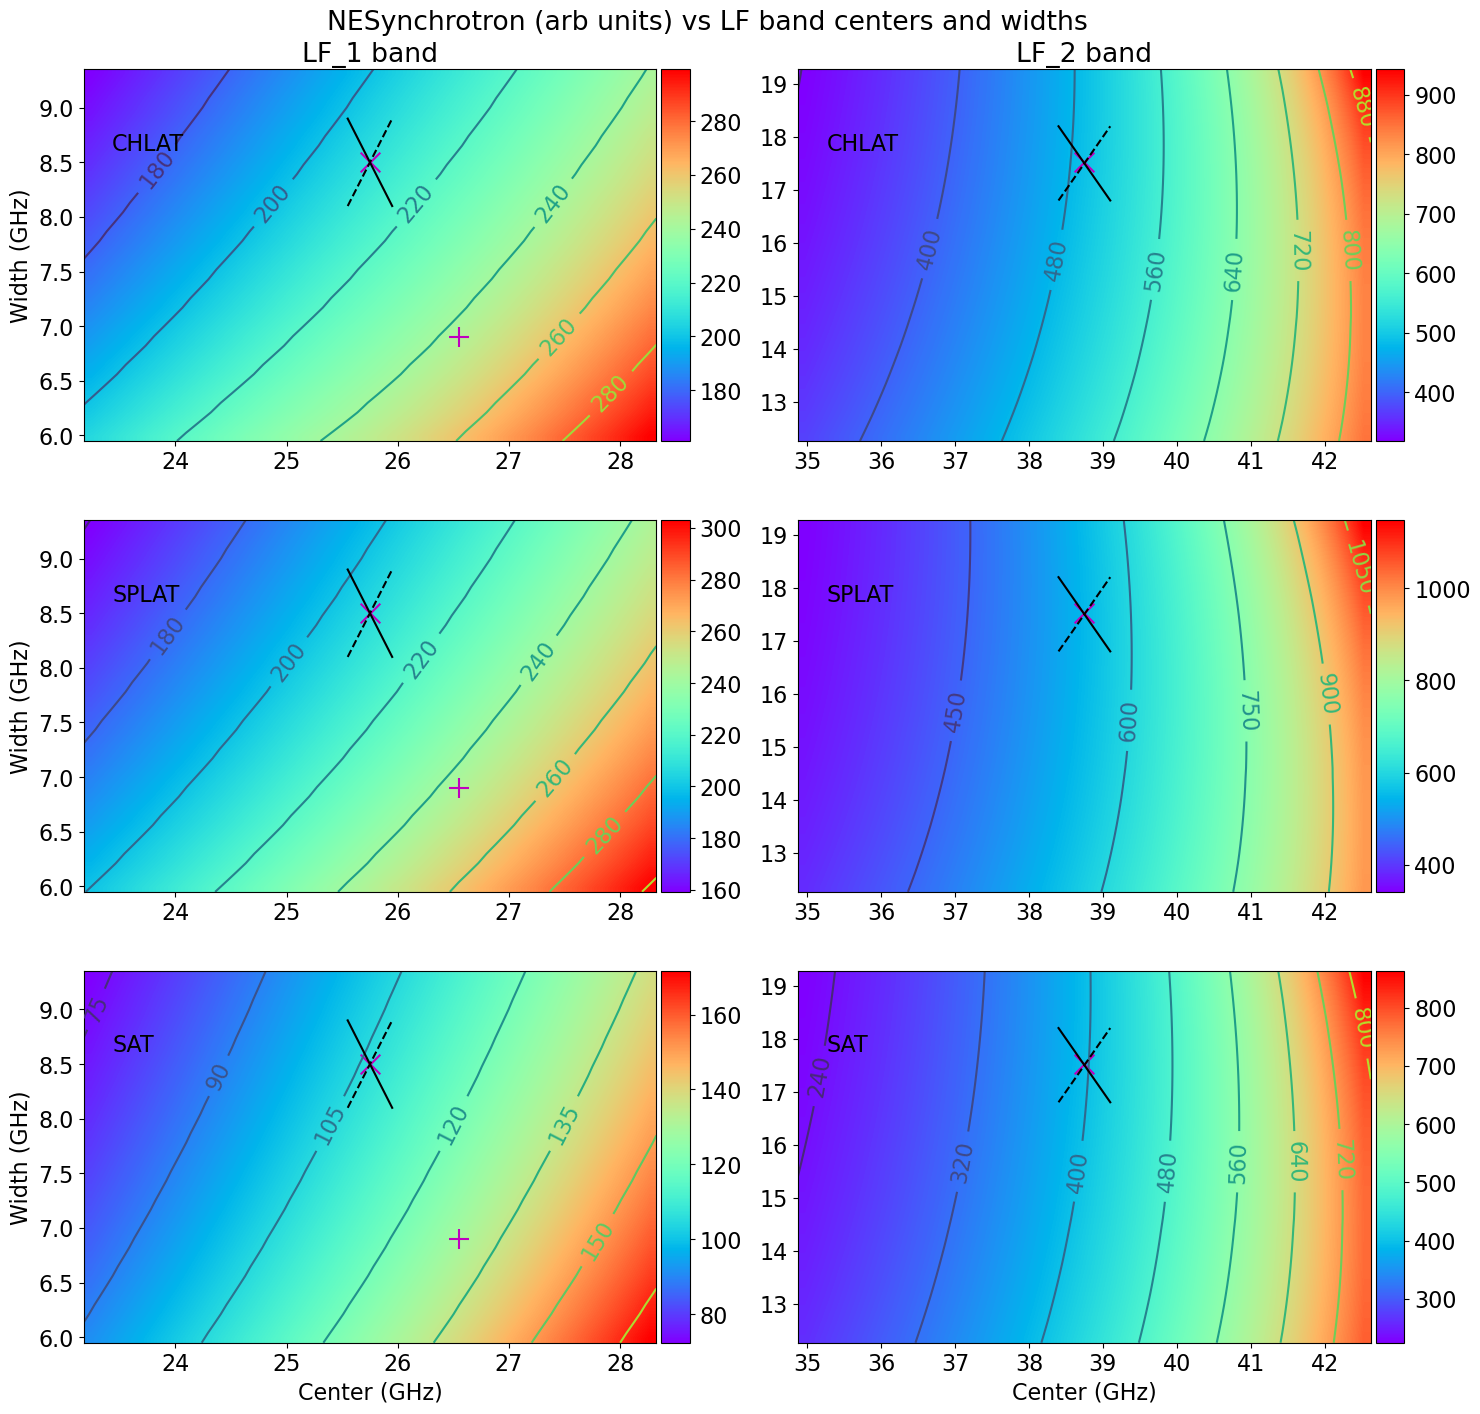

In [6]:
plt.rcParams['figure.figsize'] = [14, 14]
plt.rcParams.update({'font.size': 16})

# Proposaed new LF_1 band, which has same upper edge, and lower edge at 21.7GHz
#
LF_1_newcenter = (30.0+23.1)/2.
LF_1_newwidth = 30.0 - 23.1

nu_synch0 = 30 # GHz, reference frequency for sync scaling

# make a line that goes through the old center for the LF_1 band
x0_1 = (30+21.5)/2
y0_1 = (30-21.5)
dnu_1 = np.linspace(-0.4,.4,100)  # amount low edge of band moves up, 0 to 2 GHz
x_1_movelow = x0_1 + dnu_1/2  # center of band moves up by dnu/2
y_1_movelow = y0_1 - dnu_1    # bandwidth gets smaller by dnu
x_1_movehigh = x0_1 + dnu_1/2  # center of band moves up by dnu/2
y_1_movehigh = y0_1 + dnu_1    # bandwidth gets smaller by dnu

#
# make a line that goes through the old center for the LF_2 band
x0_2 = (47.5 + 30.0)/2
y0_2 = (47.5-30.0)
dnu_2 = np.linspace(-0.7,0.7,100)  # amount low edge of band moves up, 0 to 2 GHz
x_2_movelow = x0_2 + dnu_2/2  # center of band moves up by dnu/2
y_2_movelow = y0_2 - dnu_2    # bandwidth gets smaller by dnu
x_2_movehigh = x0_2 + dnu_2/2  # center of band moves up by dnu/2
y_2_movehigh = y0_2 + dnu_2    # bandwidth gets smaller by dnu

npl_x = 2
npl_y = 3

fig, axs = plt.subplots(nrows=npl_y,ncols=npl_x,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.1,
                                wspace=0.1)

# CHLAT, LF_1
rownum = 0
for tel in ['CHLAT','SPLAT','SAT']:
    colnum = 0
    for ch in ['LF_1','LF_2']:
        netarr = 1e6*out[tel]['NETrj'][ch]
        centerfreq = out[tel]['center'][ch]
        valmap = netarr*(centerfreq/nu_synch0)**2.7
        abc= axs[rownum,colnum].imshow(valmap,interpolation='bilinear',cmap='rainbow',origin='lower',aspect='auto',extent=(np.min(out[tel]['center'][ch]),np.max(out[tel]['center'][ch]),np.min(out[tel]['width'][ch]),np.max(out[tel]['width'][ch])))
        
        cvec = out[tel]['center'][ch][0,:]
        wvec = out[tel]['width'][ch][:,0]
        cset = axs[rownum,colnum].contour(cvec,wvec,valmap) #,levels,colors='w')
        axs[rownum,colnum].clabel(cset)#, levels,fmt='%i mK',fontsize=8)
        axs[rownum,colnum].text(0.05, 0.8, tel, horizontalalignment='left',verticalalignment='center', transform=axs[rownum,colnum].transAxes)
        divider = make_axes_locatable(axs[rownum,colnum])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        axs[rownum,colnum].scatter(sim['channels'][ch]['nu_center0'],sim['channels'][ch]['nu_width0'],s=200,marker='x',c='m')
        fig.colorbar(abc, cax=cax, orientation='vertical')
        colnum = colnum + 1
    rownum = rownum + 1
    
for row in [0,1,2]:
    axs[row,0].scatter(LF_1_newcenter,LF_1_newwidth,s=200,marker='+',c='m')
    axs[row,0].plot(x_1_movelow,y_1_movelow,'-k')
    axs[row,1].plot(x_2_movelow,y_2_movelow,'-k')
    axs[row,0].plot(x_1_movehigh,y_1_movehigh,'--k')
    axs[row,1].plot(x_2_movehigh,y_2_movehigh,'--k')
    axs[row,0].set_ylabel('Width (GHz)')

                                                                          
axs[0,0].set_title('LF_1 band')
axs[0,1].set_title('LF_2 band')
#for jj in range(len(chlist)):
#    axs[jj,0].set_ylabel('width (GHz)')
#axs[0,3].legend(loc='upper right')
axs[npl_y-1,0].set_xlabel('Center (GHz)')
axs[npl_y-1,1].set_xlabel('Center (GHz)')

fig.suptitle('NESynchrotron (arb units) vs LF band centers and widths')
        

# Plot cuts along lines moving lower or upper edge.

Text(0.5, 0.98, 'LF_1')

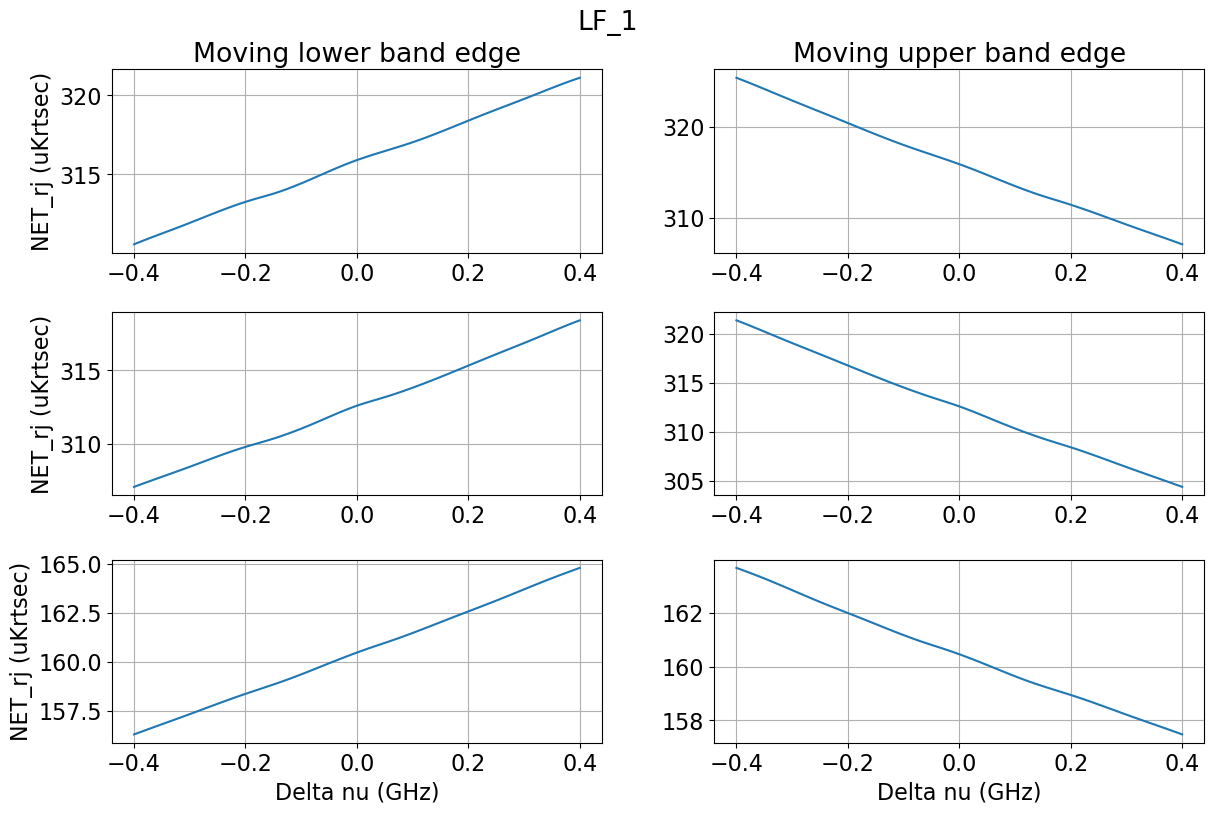

In [7]:
import scipy.interpolate as interp
plt.rcParams['figure.figsize'] = [12, 8]

fig, axs = plt.subplots(nrows=3,ncols=2,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.1, wspace=0.1)

prow = 0
pcol = 0
for tel in tels:
    x = out[tel]['center']['LF_1']
    y = out[tel]['width']['LF_1']
    z = out[tel]['NETrj']['LF_1']
    f = interp.interp2d(x, y, z,kind='cubic')
    znew = np.empty(len(dnu_1))
    for ii in range(len(dnu_1)):
        znew[ii] = f(x_1_movelow[ii],y_1_movelow[ii])
    axs[prow][pcol].plot(dnu_1,1e6*znew)
    #plt.ylabel('NET_rj')
    #plt.xlabel('Delta nu')
    axs[prow][pcol].grid()
    
    pcol = pcol + 1
    znew = np.empty(len(dnu_1))
    for ii in range(len(dnu_1)):
        znew[ii] = f(x_1_movehigh[ii],y_1_movehigh[ii])
    axs[prow][pcol].plot(dnu_1,1e6*znew)
    #plt.ylabel('NET_rj')
    #plt.xlabel('Delta nu')
    axs[prow][pcol].grid()
    
    prow = prow + 1
    pcol = 0
    
axs[0][0].set_title('Moving lower band edge')
axs[0][1].set_title('Moving upper band edge')
axs[2][0].set_xlabel('Delta nu (GHz)')
axs[2][1].set_xlabel('Delta nu (GHz)')

for yy in [0,1,2]:
    axs[yy][0].set_ylabel('NET_rj (uKrtsec)')

fig.suptitle('LF_1')


/Users/ruhl/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=44,45 m=1600 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/Users/ruhl/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=33,39 m=1600 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/Users/ruhl/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable cause

Text(0.5, 0.98, 'LF_2')

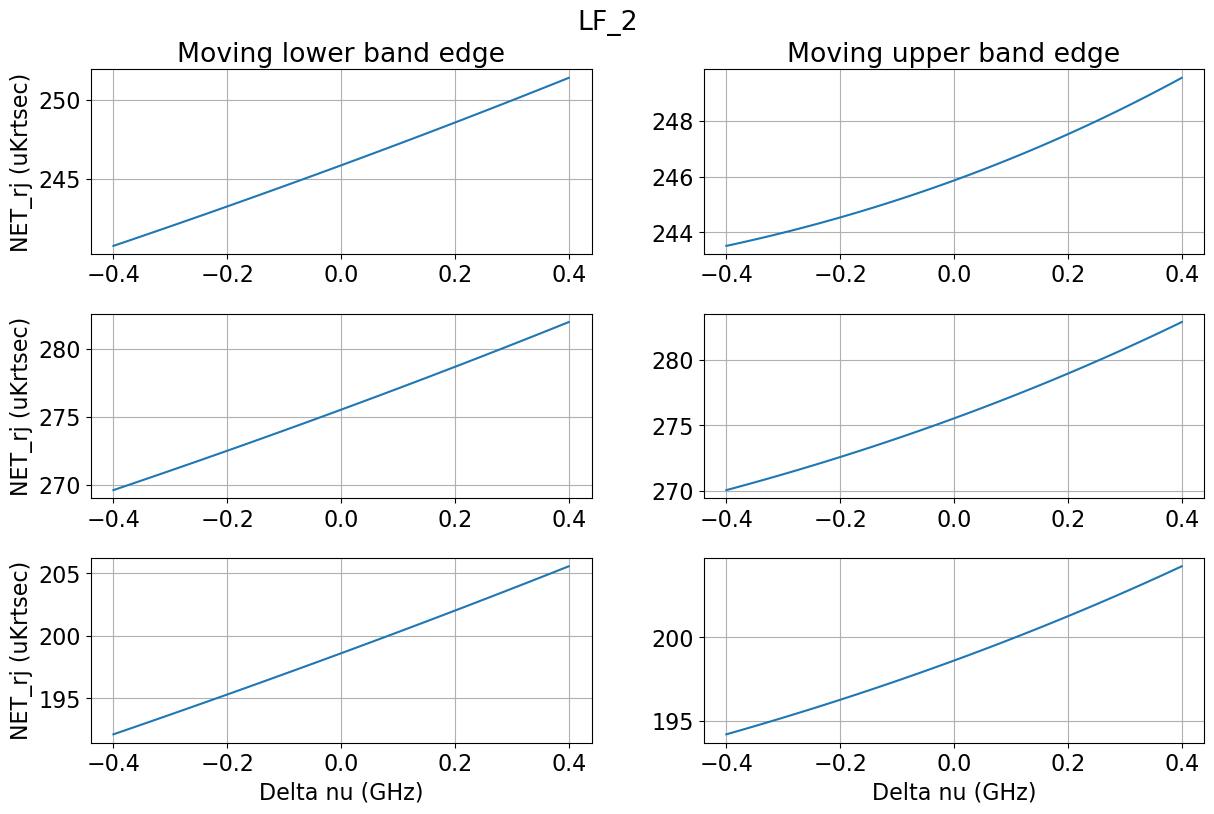

In [8]:
fig, axs = plt.subplots(nrows=3,ncols=2,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.1, wspace=0.1)

prow = 0
pcol = 0
for tel in tels:
    x = out[tel]['center']['LF_2']
    y = out[tel]['width']['LF_2']
    z = out[tel]['NETrj']['LF_2']
    f = interp.interp2d(x, y, z,kind='cubic')
    znew = np.empty(len(dnu_2))
    for ii in range(len(dnu_2)):
        znew[ii] = f(x_2_movelow[ii],y_2_movelow[ii])
    axs[prow][pcol].plot(dnu_1,1e6*znew)
    #plt.ylabel('NET_rj')
    #plt.xlabel('Delta nu')
    axs[prow][pcol].grid()
    
    pcol = pcol + 1
    znew = np.empty(len(dnu_1))
    for ii in range(len(dnu_1)):
        znew[ii] = f(x_2_movehigh[ii],y_2_movehigh[ii])
    axs[prow][pcol].plot(dnu_1,1e6*znew)
    #plt.ylabel('NET_rj')
    #plt.xlabel('Delta nu')
    axs[prow][pcol].grid()
    
    prow = prow + 1
    pcol = 0
    
axs[0][0].set_title('Moving lower band edge')
axs[0][1].set_title('Moving upper band edge')
axs[2][0].set_xlabel('Delta nu (GHz)')
axs[2][1].set_xlabel('Delta nu (GHz)')

for yy in [0,1,2]:
    axs[yy][0].set_ylabel('NET_rj (uKrtsec)')

fig.suptitle('LF_2')

# Interpretation of the plots above
We need to reduce the overall bandwith of LF_1 + LF_2, so we need to move the lower edge of LF_1 upward, the upper edge of LF_2 downward, or both.  

First, at the level of movement we're showing here, the changes in NET are not large, order(2%).  So, we can probably do whatever we want here, and any optimizations are very small effects.

The LF_1 plots show that NET increases as we bring up the lower edge of that band.  Interestingly, the LF_2 plots show that as we bring down its upper edge, the NET decreases, which is good.  So, in terms of NET, we'd rather bring down the upper edge of LF_2 rather than bring up the lower edge of LF_1.

Moving down the upper edge of LF_2 is also preferable in terms of keeping these bands sensitive to the synchrotron foregrounds.

So, to the extent possible, we should favor moving down the upper edge of LF_2, or combination of moving both.

On 2/1/2023, flowdown call with JK, SS, JR, and BobbyB, we agreed to:
 - move LF_1 edge to 23.1 GHz lower edge.
 - keep total fractional bandwidth <= what is now in the MF's and HF's.
 - use jbolo to figure out where to put the crossover point.
 
The current MF band edges (for LATs) are 77.0 and 169.0 GHz, so (high_edge/low_edge) = 2.195.
The current HF band edges (for LATs) are 197.9 and 315.0 GHz, so (high_edge/low_edge) = 1.592

so clearly the MF's are the widest.  So, top edge of the LF_2 band needs to be at or below 2.195*23.1 = 50.7GHz.



In [9]:
# Print info based on 2021 instrument description
print('LAT MF bands (high/low) edge ratio is: {0:5.3f}'.format(169.0/77.0))
print('LAT HF bands (high/low) edge ratio is: {0:5.3f}'.format(315.0/197.9))
print('So, LF upper frequency should be less than or equal to: {0:5.3f} GHz'.format(23.1*(169.0/77.0)))

LAT MF bands (high/low) edge ratio is: 2.195
LAT HF bands (high/low) edge ratio is: 1.592
So, LF upper frequency should be less than or equal to: 50.700 GHz


# Plot NETs of LF_1 and LF_2 vs crossover split frequency.

In [10]:
sim = {}

tels = ['CHLAT','SPLAT','SAT']
yamls = {'CHLAT':'CHLAT_20230122.yaml','SPLAT':'SPLAT_20230122.yaml','SAT':'SAT_20230122.yaml'}
chlist =['LF_1','LF_2'] #channels to deal with

out = {}  # outputs we're saving for later plotting
for tel in tels:
    out[tel]={}
    for ch in chlist:
        out[tel][ch]={'NET':np.array([]), 'NETrj':np.array([]), 'Popt':np.array([]), 'nu_split':np.array([]) }
        

# number of frequencies to plot for
nbins = 100
lowedge = 23.1  # lower edge of LF_1, in GHz
highedge = 45.0 #47.5 # upper edge of LF_2, in GHz
nu_split_vec = np.linspace(27,33,nbins)



for tel in tels:
    yamlfile = yamls[tel]
    print(yamlfile)
    sim.clear()
    sim = yaml.safe_load(open('yamls/'+yamlfile))

    # The bands in the yaml file are flat bands;  let's use the edges to determine
    # the default band center and width, and then vary those by +- 5% in band center and width.
    # This will create a 2D array of input (center,width) parameters, and we'll calculate
    # P_optical and NET for each point in the 2D space.
    #
 
    plottitle= sim['sources']['atmosphere']['site']+', pvw='+str(sim['sources']['atmosphere']['pwv'])
    print(plottitle)

    mm = 0  # this serves as an array index for the "width factor"
    for nu_split in nu_split_vec:
        if 'outputs' in sim.keys():  
            sim['outputs'].clear()  # Clear previous iteration results so things don't multiply.
    
        # set the LF band edges correctly
        sim['channels']['LF_1']['nu_low']  = lowedge
        sim['channels']['LF_1']['nu_high'] = nu_split
        sim['channels']['LF_2']['nu_low']  = nu_split
        sim['channels']['LF_2']['nu_high'] = highedge

        # this runs on all channels (flat bands)
        run_optics(sim)
        run_bolos(sim)
        
        for ch in chlist:
            
            out[tel][ch]['NET']     = np.append(out[tel][ch]['NET'],   sim['outputs'][ch]['NET_NC_total'])
            out[tel][ch]['NETrj']   = np.append(out[tel][ch]['NETrj'], sim['outputs'][ch]['NETrj_NC_total'])
            out[tel][ch]['Popt']    = np.append(sim['outputs'][ch]['P_opt'],out[tel][ch]['Popt'])
            out[tel][ch]['nu_split']= np.append(out[tel][ch]['nu_split'],nu_split)

        mm += 1


CHLAT_20230122.yaml
Atacama, pvw=993
SPLAT_20230122.yaml
Pole, pvw=321
SAT_20230122.yaml
Pole, pvw=321


Text(0.5, 0, 'Split frequency (GHz)')

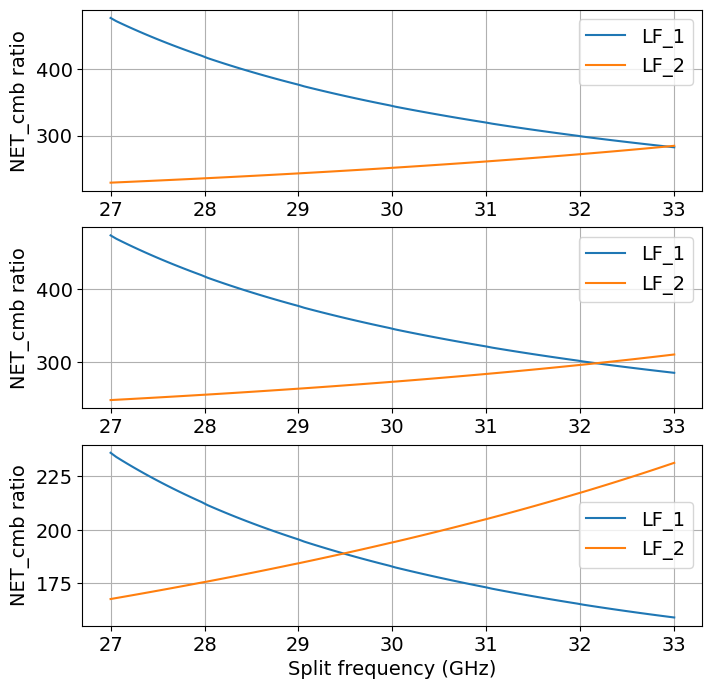

In [11]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 14})
pp = 1
for tel in tels:
    plt.subplot(3,1,pp)
    y1 = 1e6*out[tel]['LF_1']['NET']
    #y1 = y1/y1[int(nbins/2)]
    y2 = 1e6*out[tel]['LF_2']['NET']
    #y2 = y2/y2[int(nbins/2)]
    plt.plot(out[tel]['LF_1']['nu_split'],y1,label="LF_1")
    plt.plot(out[tel]['LF_2']['nu_split'],y2,label="LF_2")
    #plt.ylim(0.7,1.3)
    #plt.ylim(0)
    plt.legend()
    #plt.text(27,0.95,tel)
    plt.ylabel('NET_cmb ratio')
    plt.grid()
    pp = pp+1
plt.subplot(3,1,3)
plt.xlabel('Split frequency (GHz)')

Replot these as "sensitivity to synchroton", by considering that in T_cmb units (at low frequency) a synchrotron source has a power law index of $\alpha \sim -2.7$.  So, I will scale the NETs by (band center)$^{2.7}$ .

Text(0.5, 0, 'Split frequency (GHz)')

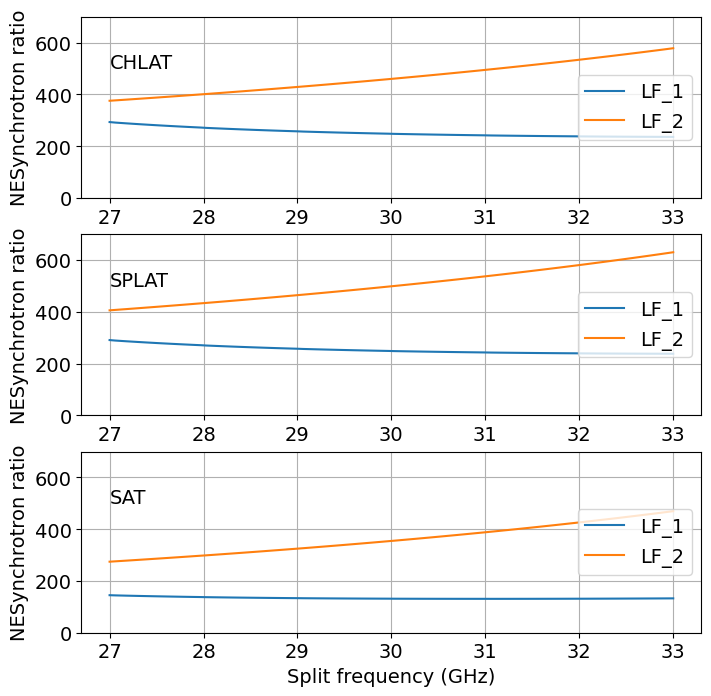

In [12]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 14})
LF1_bandcenter_vec = (nu_split_vec + lowedge)/2
LF2_bandcenter_vec = (nu_split_vec + highedge)/2

pp = 1
for tel in tels:
    plt.subplot(3,1,pp)
    y1 = 1e6*out[tel]['LF_1']['NET']*(LF1_bandcenter_vec/nu_synch0)**2.7
    #y1 = y1/y1[int(nbins/2)]
    y2 = 1e6*out[tel]['LF_2']['NET']*(LF2_bandcenter_vec/nu_synch0)**2.7
    #y2 = y2/y2[int(nbins/2)]
    
    plt.plot(out[tel]['LF_1']['nu_split'],y1,label="LF_1")
    plt.plot(out[tel]['LF_2']['nu_split'],y2,label="LF_2")
    #plt.ylim(0.8,1.2)
    plt.ylim(0,700)
    plt.text(27,500,tel)
    plt.legend(loc='center right')
    plt.ylabel('NESynchrotron ratio')
    plt.grid()
    pp = pp+1
    
plt.subplot(3,1,3)
plt.xlabel('Split frequency (GHz)')